In [1]:
!module load cuda

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from jupyterplot import ProgressPlot
from tqdm import tqdm, trange
import seaborn as sns

In [3]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data = 'data/big_arpafvg.csv', img_dir = 'data/cut_images'):
        initial_data=pd.read_csv(weather_data)
        initial_data = initial_data.drop(columns=['Temp. min gradi C','Temp. med gradi C','Temp. max gradi C','Vento med km/h','Dir. V. max gradi N'])
        #normalize the data
        for col in initial_data.columns:
            if col != 'giorno' and col != 'mese' and col != 'anno':
                initial_data[col] = (initial_data[col] - initial_data[col].mean()) / initial_data[col].std()
        self.weather_data = initial_data
        self.img_dir = img_dir

    def __getitem__(self, date):
        #get day month year from date in format dd-mm-yyyy
        day, month, year = date.split('_')
        #get from weather data the row with the same date
        weather_data = self.weather_data[(self.weather_data['giorno'] == int(day)) & (self.weather_data['mese'] == int(month)) & (self.weather_data['anno'] == int(year))]
        weather_data = torch.tensor(weather_data.values[0])

        image = os.path.join(self.img_dir, str(date) + '.jpg')  
        image = read_image(image)   
        return [image, weather_data]
    
    def __len__(self):
        return len(self.weather_data)

In [4]:
dataset = WeatherDataset()

In [5]:
from datetime import datetime, timedelta
start_date = datetime.strptime("01_01_2022", "%d_%m_%Y")
end_date = datetime.strptime("15_06_2024", "%d_%m_%Y")
date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days)]
date_generated = [date.strftime("%d_%m_%Y") for date in date_generated]


In [6]:
train_len = int(0.8 * len(date_generated))
test_len = len(date_generated) - train_len
#split the dataset: date_trainset contains the first 80% of the dates, date_testset contains the remaining 20%
date_trainset = date_generated[:train_len]
date_testset = date_generated[train_len:]

In [7]:
class DeepWeather(nn.Module):
    def __init__(self):
        super(DeepWeather, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3, 3), stride = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p = 0.3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3), stride = 1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3), stride = 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), stride = 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), stride = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), stride = 1)
        self.bn6 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(6154, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, inputs):
        x1, x2 = inputs[0], inputs[1]
        
        x1 = self.bn1(self.dropout(self.pool(F.leaky_relu(self.conv1(x1)))))
        x1 = self.bn2(self.dropout(self.pool(F.leaky_relu(self.conv2(x1)))))
        x1 = self.bn3(self.dropout(self.pool(F.leaky_relu(self.conv3(x1)))))
        x1 = self.bn4(self.dropout(self.pool(F.leaky_relu(self.conv4(x1)))))
        x1 = self.bn5(self.dropout(self.pool(F.leaky_relu(self.conv5(x1)))))
        x1 = self.bn6(self.dropout(self.pool(F.leaky_relu(self.conv6(x1)))))
        x1 = torch.flatten(x1, start_dim = 1)

        x = torch.cat((x1, x2), dim = 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [8]:
def train(model, dataset, batch_size,date_trainloader, date_testloader, criterion, optimizer, epochs):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    train_loss_epochs = []
    test_loss_epochs = []
    bar = trange(epochs, desc=f"Epoch ?/?, Train Loss: ?, Test Loss: ?")
    for epoch in bar:
        model.train()
        train_losses = []
        for date_inputs in date_trainloader:
            for date_idx in range(batch_size):
                #print(f'date inputs{date_inputs[date_idx]} and this is the index {date_idx}')
                
                date_input=date_inputs[date_idx]
            

                inputs = dataset[date_input]
                #convert to right type, size and load to device
                inputs = [inputs[0].float().unsqueeze(0).to(device), inputs[1].float().unsqueeze(0).to(device)]

                #increment of 1 day the date_inputs
                date_next_day = date_input.split('_')
                date_next_day = datetime(int(date_next_day[2]), int(date_next_day[1]), int(date_next_day[0])) + timedelta(days = 1)
                date_next_day = date_next_day.strftime("%d_%m_%Y")
                target=dataset[date_next_day][1][3].float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), target)
                train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss_epochs.append(np.mean(train_losses))
        model.eval()
        test_losses = []
        for date_inputs in date_testloader:
            for date_idx in range(batch_size):
                date_input=date_inputs[date_idx]

                inputs = dataset[date_input]
                #convert to right type, size and load to device
                inputs = [inputs[0].float().unsqueeze(0).to(device), inputs[1].float().unsqueeze(0).to(device)]

                #increment of 1 day the date_inputs
                date_next_day = date_input.split('_')
                date_next_day = datetime(int(date_next_day[2]), int(date_next_day[1]), int(date_next_day[0])) + timedelta(days = 1)
                date_next_day = date_next_day.strftime("%d_%m_%Y")
                target=dataset[date_next_day][1][3].float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), target)
                test_losses.append(loss.item())
                
        test_loss_epochs.append(np.mean(test_losses))
        bar.set_description(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses)}, Test Loss: {np.mean(test_losses)}")


    return train_loss_epochs, test_loss_epochs

In [9]:
model = DeepWeather()
batch_size = 4

date_trainloader = DataLoader(date_trainset, batch_size = batch_size, shuffle = False)

date_testloader = DataLoader(date_testset, batch_size = batch_size, shuffle = False)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-6, weight_decay=1e-5)

In [10]:
train_losses, test_losses = train(model, dataset, batch_size, date_trainloader, date_testloader, criterion, optimizer, epochs = 50)
#torch.save(model.state_dict(), "models/model_2dcnn_noweek.tensor")

In [11]:
epochs = [epoch for epoch in range(50)]
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, test_losses, label='Validation Loss', color='mediumaquamarine')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("plots/2dcnn_noweek_loss.png")
plt.show()

NameError: name 'train_losses' is not defined

In [12]:
state_dict=torch.load("models/model_2dcnn_noweek.tensor")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
def predict(model, date):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model=model.to(device)
    inputs = dataset[date]
    inputs = [inputs[0].float().unsqueeze(0).to(device), inputs[1].float().unsqueeze(0).to(device)]

    outputs = model(inputs)    
    
    return outputs

In [30]:
predictions=[]
reals=[]
for date in date_testset:
    predicted_rain = predict(model, date)
    #print(predicted_rain)
    #print(predicted_rain.cpu().detach().numpy())
    predictions.append(predicted_rain.cpu().detach().numpy()[0][0])
    reals.append(dataset[date][1][3].cpu())

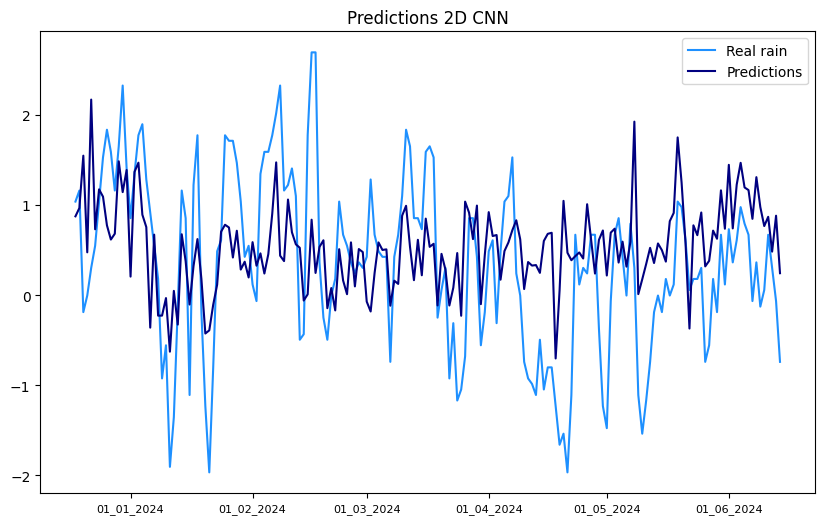

<Figure size 640x480 with 0 Axes>

In [32]:
predicted_days = np.array(date_testset)
real_rain = np.array(reals)
predictions=np.array(predictions)

date_to_display = ['01_01_2024', '01_02_2024', '01_03_2024', '01_04_2024', '01_05_2024', '01_06_2024']

indices_to_display = [np.where(predicted_days == date)[0][0] for date in date_to_display if date in predicted_days]

plt.figure(figsize=(10, 6))
sns.lineplot(x=predicted_days, y=real_rain, label='Real rain', color='dodgerblue')
sns.lineplot(x=predicted_days, y=predictions, label='Predictions', color='navy')

plt.xticks(predicted_days[indices_to_display], date_to_display, fontsize=8)

plt.title('Predictions 2D CNN')
plt.legend()
plt.savefig("plots/2dcnn_noweek_pred.png")
plt.show()